In [1]:
import mitsuba as mi
mi.set_variant("llvm_ad_rgb")
import drjit as dr

import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np
from scipy.integrate import quad
from ipywidgets import interact

# 1. Discontinuities due to moving geometry

For the first example, let us consider a simple 1D function

$$
f(x, \pi) =
\chi^+(x - \pi)
\cdot
\exp(- \frac{(x - \mu)^2}{2\sigma^2}),
$$

i.e. the product between an unormalized Gaussian (with mean $\mu$ and std. deviation $\sigma$) and a step function $\chi^+$ (where $\chi^+(x)$ is $1$ if $x > 0$ and 0 otherwise).

This imitates the case in rendering where a discontinuity in the incident illumination (e.g. an object silhouette) moves due to scene parameter $\pi$.

We are interested in the derivatives of its integral over $\mathbb{R}$:

$$
\partial_\pi
\int_\mathbb{R}
f(x, \pi) \,\mathrm{d}x
$$

In [3]:
def gaussian(x, mu, sigma):
    tmp = (x - mu)**2 / (2*sigma**2)
    return dr.exp(-((x - mu)**2)/(2*sigma**2))

# Test function
def f(x, pi):
    return dr.select(x > pi, gaussian(x, mu[0], sigma[0]), 0.0)

# Gaussian parameters (fixed)
mu    = mi.Float(0.0)
sigma = mi.Float(2.0)

# "Differentiable scene parameter" controlling the position of the step function
pi = mi.Float(-1.0)

In [6]:
# Interactive visualization of the setup:
# a small perturbation `delta` is applied to the position of the step function (`pi`)
@interact(delta=(-0.5, 0.5, 0.1))
def plot_sitation(delta=0.0):
    N = 1000
    x = dr.linspace(mi.Float, -8, 8, N)
    plt.figure()
    plt.plot(x, f(x, pi[0]+delta), 'k', lw=2, label=r'$f(x, \pi)$')
    plt.xlim([-8, 8])
    plt.legend()
    plt.title("1D setup", weight='bold')
    plt.tight_layout()
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='delta', max=0.5, min=-0.5), Output()), _dom_classes=…

In [7]:
# Compute reference integral ...
pi0 = pi[0]
I_ref = quad(lambda x : f(x, pi0), -100, 100)[0]
print("Primal ref:\t", I_ref)

# .. and reference derivative via finite differences.
fd_eps = 1e-4
pi1 = pi0 + fd_eps
i1 = quad(lambda x : f(x, pi1), -100, 100)[0]
i0 = quad(lambda x : f(x, pi0), -100, 100)[0]
dI_ref = (i1 - i0) / fd_eps
print("Derivative ref:\t", dI_ref)

Primal ref:	 3.4664787125139602
Derivative ref:	 -0.8824688773545475


It is very straightforward to evaluate the _primal_ integral using Monte Carlo. E.g. using a Gaussian PDF for importance sampling:

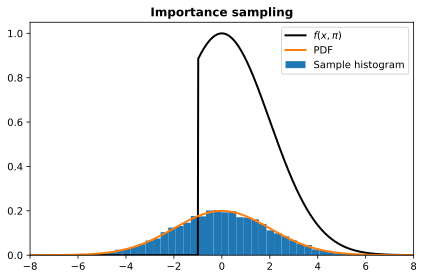

Primal ref:	 3.4664787125139602
MC integral:	 3.4357311725616455


In [9]:
def pdf(x):
    return dr.rcp(dr.sqrt(2*np.pi)*sigma) * gaussian(x, mu, sigma)

def sample(u):
    x_std = dr.sqrt(2)*dr.erfinv(2*u - 1)
    return mu + x_std*sigma

# Visualize sampling density & histogram
N = 1000
U = 10000
np.random.seed(0)
u = mi.Float(np.random.uniform(size=U))
x = sample(u)

plt.figure()
plt.hist(x, density=True, bins=50, label='Sample histogram')
x = dr.linspace(mi.Float, -8, 8, N)
plt.plot(x, f(x, pi[0]), 'k', lw=2, label=r'$f(x, \pi)$')
plt.plot(x, pdf(x), lw=2, label='PDF')
plt.xlim([-8, 8])
plt.legend()
plt.title("Importance sampling", weight='bold')
plt.tight_layout()
plt.show()

# Apply Monte Carlo to primary integral
n_samples = 10000
np.random.seed(0)
u = mi.Float(np.random.uniform(size=n_samples))
x = sample(u)
weight = f(x, pi[0]) / pdf(x)
estimate = dr.sum(weight) / n_samples

print("Primal ref:\t", I_ref)
print("MC integral:\t", estimate[0])

Estimating the gradients using a Monte Carlo estimator is more challenging on the other hand.

Initially, we might be tempted to simply exchange the order of integration and differentiation, i.e.

$$
\partial_\pi
\int_\mathbb{R}
f(x, \pi) \,\mathrm{d}x
\;
\stackrel{?}{=}
\;
\int_\mathbb{R}
\partial_\pi
f(x, \pi) \,\mathrm{d}x,
$$

but this completely neglects the discontinuity and the resulting estimate is zero!

In [11]:
# Detached MC estimator for derivatives.

dr.enable_grad(pi)

n_samples = 10000
np.random.seed(0)
u = mi.Float(np.random.uniform(size=n_samples))
x = sample(u)
weight = f(dr.detach(x), pi) / dr.detach(pdf(x))
estimate = dr.sum(weight) / n_samples

dr.forward(pi)

print("Diff. ref:\t", dI_ref)
print("MC integral:\t", dr.grad(estimate)[0], " <-- wrong!")

Diff. ref:	 -0.8824688773545475
MC integral:	 0.0  <-- wrong!


Instead, we should apply a change of variables

$$
\partial_\pi
\int_\mathbb{R}
f(R(x, \pi), \pi) \, |J_R(x, \pi)| \,\mathrm{d}x
$$

that freezes the problematic discontinuity in place.

In this toy example, a simple reparameterization

$$
R(x, \pi) = x + \pi - \pi_0,
$$

is sufficient. Here, $\pi_0$ is the "detached" version of $\pi$ that matches its primal value but is unaffected by differentiation.

This example is particularly simple because the Jacobian determinant $|J_R|$ evaluates to $1$ and has zero derivatives $\partial_\pi |J_R| = 0$. I.e. there is no expansion or contraction introduced by $R$.

In [12]:
# Detached MC estimator for derivatives, after applying a reparameterization.

dr.enable_grad(pi)

def reparam(x, pi):
    return x + pi - dr.detach(pi)

n_samples = 10000
np.random.seed(0)
u = mi.Float(np.random.uniform(size=n_samples))
x = dr.detach(sample(u))
x_R = reparam(x, pi)
weight = f(x_R, pi) / dr.detach(pdf(x_R))
estimate = dr.sum(weight) / n_samples

dr.forward(pi)

print("Diff. ref:\t", dI_ref)
print("MC integral:\t", dr.grad(estimate)[0])

Diff. ref:	 -0.8824688773545475
MC integral:	 -0.8725928664207458


# 2. Discontinuities due to attached sampling

As a second example, we look at a slightly modified setup

$$
f(x, \pi) =
\chi^+(x - 1)
\cdot
\exp(- \frac{(x - \mu)^2}{2\pi^2}),
$$

where the step function discontinuity remains constant (at $x=-1$) and instead, $\pi$ controls the standard deviation of the Gaussian.

Like before, we are interested in the derivative of the integrated function over $\mathbb{R}$:

$$
\partial_\pi
\int_\mathbb{R}
f(x, \pi) \,\mathrm{d}x
$$

The primal integral is unchanged from the previous example, and the discontinuity is now static with respect to $\pi$.

In [13]:
step = -1.0

# Test function
def f(x, pi):
    return dr.select(x > step, gaussian(x, mu[0], pi), 0.0)

# "Differentiable scene parameter" controlling the Gaussian standard deviation
pi = mi.Float(2.0)

# PDF and sampling transform now also depend on `pi` which allows us to perform attached sampling.
def pdf(x, pi):
    # (!) There is an unfortunate notational overlap here between
    # the circle constant `dr.pi` and the scene parameter `pi`.
    return dr.rcp(dr.sqrt(2*dr.pi)*pi) * gaussian(x, mu, pi)

def sample(u, pi):
    x_std = dr.sqrt(2)*dr.erfinv(2*u - 1)
    return mu + x_std*pi

In [14]:
# Interactive visualization of the setup:
# a small perturbation `delta` the diff. parameter `pi`
@interact(delta=(-0.5, 0.5, 0.1))
def plot_sitation(delta=0.0):
    N = 1000
    x = dr.linspace(mi.Float, -8, 8, N)
    plt.figure()
    plt.plot(x, f(x, pi[0]+delta), 'k', lw=2, label=r'$f(x, \pi)$')
    plt.xlim([-8, 8])
    plt.legend()
    plt.title("1D setup", weight='bold')
    plt.tight_layout()
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='delta', max=0.5, min=-0.5), Output()), _dom_classes=…

In [15]:
# Compute reference integral ...
pi0 = pi[0]
I_ref = quad(lambda x : f(x, pi0), -100, 100)[0]
print("Primal ref:\t", I_ref)

# .. and reference derivative via finite differences.
fd_eps = 1e-4
pi1 = pi[0]; pi2 = pi1 + fd_eps
i2 = quad(lambda x : f(x, pi2), -100, 100)[0]
i1 = quad(lambda x : f(x, pi1), -100, 100)[0]
dI_ref = (i2 - i1) / fd_eps
print("Derivative ref:\t", dI_ref)

Primal ref:	 3.4664787125139602
Derivative ref:	 1.2919881474005024


Because the discontinuity is static (w.r.t. $\pi$), we can this time safely exchange the order of operations:

$$
\partial_\pi
\int_\mathbb{R}
f(x, \pi) \,\mathrm{d}x
\;
=
\;
\int_\mathbb{R}
\partial_\pi
f(x, \pi) \,\mathrm{d}x,
$$

and the derivative integral can be approximated easily with a detached estimator.

In [16]:
# Detached MC estimator for derivatives.

dr.enable_grad(pi)

n_samples = 10000
np.random.seed(0)
u = mi.Float(np.random.uniform(size=n_samples))
x = sample(u, pi0)
weight = f(dr.detach(x), pi) / dr.detach(pdf(x, pi0))
estimate = dr.sum(weight) / n_samples

dr.forward(pi)

print("Diff. ref:\t", dI_ref)
print("MC integral:\t", dr.grad(estimate)[0])

Diff. ref:	 1.2919881474005024
MC integral:	 1.274256944656372


However, the situation is different for _attached_ estimators! These now introduce a new parameter-dependent discontinuity because the integral is reparameterized over random number space $U$:

$$
\partial_\pi
\int_\mathbb{R}
f(x, \pi)
\,\mathrm{d}x
\;
=
\partial_\pi
\int_U
\frac{f(T(u, \pi), \pi)}{p(T(u, \pi), \pi)}
\,\mathrm{d}u
$$

This causes the estimate to be biased.

In [17]:
# Naïve attached MC estimator for derivatives.

dr.enable_grad(pi)

n_samples = 10000
np.random.seed(0)
u = mi.Float(np.random.uniform(size=n_samples))
x = sample(u, pi)
weight = f(x, pi) / pdf(x, pi)
estimate = dr.sum(weight) / n_samples

dr.forward(pi)

print("Diff. ref:\t", dI_ref)
print("MC integral:\t", dr.grad(estimate)[0], " <-- wrong!")

Diff. ref:	 1.2919881474005024
MC integral:	 1.7178655862808228  <-- wrong!


Like before, we can again define a suitable reparameterization
of the integral that sidesteps this problem. This time, we use

$$
R(x, \pi) = x - B(x) \cdot T(u, \pi) + B(x) \cdot T(u, \pi_0)
$$

which uses the sampling transform $T$ (this dictates how samples move with changes of $\pi$) and a parameter-independent scale factor $B$ that is supposed to only slow down sample movement close to the discontinuity.

In [18]:
# Reparameterized attached MC estimator for derivatives.

# First, we look at a simple version that completely cancels out any sample movement.
# (This is equivalent to a detached estimator and loses all benefits from attaching.)
dr.enable_grad(pi)

def reparam(x, u, pi):
    T = sample(u, pi)
    J_T = dr.detach(pdf(T, pi)) / pdf(T, pi)
    
    # Reparameterized position: the derivatives of `x` and `T` cancel completely.
    x_R = x - T + dr.detach(T)
    # Reparameterization Jacobian. This is again the identity in the primal case,
    # but has non-trivial derivatives now.
    J_R = 1.0 - J_T + dr.detach(J_T)
    return x_R, J_R
    
n_samples = 10000
np.random.seed(0)
u = mi.Float(np.random.uniform(size=n_samples))
x = sample(u, pi)
x_R, J_R = reparam(x, u, pi)

weight = f(x_R, pi) * J_R / pdf(x, pi)
estimate = dr.sum(weight) / n_samples

dr.forward(pi)

print("Diff. ref:\t", dI_ref)
print("MC integral:\t", dr.grad(estimate)[0])

Diff. ref:	 1.2919881474005024
MC integral:	 1.274256944656372


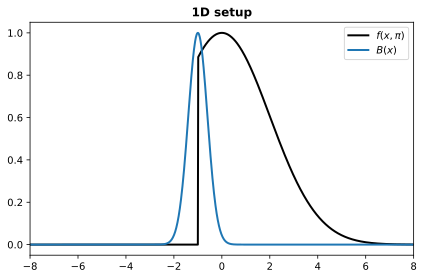

In [19]:
# Scale factor `B` and its x-derivative
sigma_B = 0.4
def B(x):
    return dr.exp(-(x - step)**2 / (2*sigma_B**2))

def dB(x):
    tmp = B(x)
    return -(x - step)*tmp / sigma_B**2

# Visualization of the scale factor `B(x)`
N = 1000
x = dr.linspace(mi.Float, -8, 8, N)
plt.figure()
plt.plot(x, f(x, pi[0]), 'k', lw=2, label=r'$f(x, \pi)$')
plt.plot(x, B(x), lw=2, label=r'$B(x)$')
plt.xlim([-8, 8])
plt.legend()
plt.title("1D setup", weight='bold')
plt.tight_layout()
plt.show()

In [20]:
# Reparameterized attached MC estimator for derivatives.

# This improved version cancels sample movement only partially,
# i.e. close to the discontinuity where it is problematic.

dr.enable_grad(pi)

def reparam(x, u, pi):
    T = sample(u, pi)
    J_T = dr.detach(pdf(T, pi)) / pdf(T, pi)
    
    # Apply the scale factor to both reparam. and its Jacobian det.
    T_ = B(dr.detach(x)) * T
    J_T_ = dB(dr.detach(x)) * T + B(dr.detach(x)) * J_T
    
    # Derivatives of `x` and `T` will be equivalent and cancel.
    return x - T_ + dr.detach(T_), 1.0 - J_T_ + dr.detach(J_T_)
    
n_samples = 10000
np.random.seed(0)
u = mi.Float(np.random.uniform(size=n_samples))
x = sample(u, pi)
x_R, J_R = reparam(x, u, pi)

weight = f(x_R, pi) * J_R / pdf(x, pi)
estimate = dr.sum(weight) / n_samples

dr.forward(pi)

print("Diff. ref:\t", dI_ref)
print("MC integral:\t", dr.grad(estimate)[0])

Diff. ref:	 1.2919881474005024
MC integral:	 1.2838093042373657
